# __Angles qualitative analysis__

### __Calculators definitions__

In [9]:
# ANI


# import the calculators
from torch import device
from torchani.models import ANI1x, ANI2x, ANI1ccx

ani1x_calc = ANI1x().ase()
ani1ccx_calc = ANI1ccx().ase()
ani2x_calc = ANI2x().ase()

# device type can defined via torch and parsed to the model via .to() method
#device_ = device('cpu')
#model_ = ANI1x(periodic_table_index=True).to(device_).double().ase()


# MACE
from mace.calculators import mace_mp, mace_off

macemp = mace_mp(
    model="medium", 
    dispersion=False, 
    default_dtype="float32", 
    device='cpu',
    )

maceoff = mace_off(
    model="medium", 
    device='cpu',
    default_dtype='float32'
    )

# ORB

from orb_models.forcefield.pretrained import orb_v2, orb_d3_v2
from orb_models.forcefield.calculator import ORBCalculator

orbff_v2 = orb_v2(device='cpu')
orb_calc_v2 = ORBCalculator(orbff_v2, device='cpu')

orbff_d3_v2 = orb_d3_v2(device='cpu')
orb_calc_d3_v2 = ORBCalculator(orbff_d3_v2, device='cpu')

/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/torchani/resources/
/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/torchani/resources/
/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/torchani/resources/
Using Materials Project MACE for MACECalculator with /Users/sergiortizropero/.cache/mace/20231203mace128L1_epoch199model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Using MACE-OFF23 MODEL for MACECalculator with /Users/sergiortizropero/.cache/mace/MACE-OFF23_medium.model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

In [10]:
# define the calculators
calculator_list = [ani1x_calc, ani1ccx_calc, ani2x_calc, macemp, maceoff, orb_calc_v2, orb_calc_d3_v2]
calculator_names = ['ANI-1x', 'ANI-1ccx', 'ANI-2x', 'MACE-MP', 'MACE-OFF', 'ORB-V2', 'ORB-D3-V2']
calculator_colors = ['darkviolet', 'crimson', 'deeppink', 'darkgreen', 'mediumseagreen', 'royalblue', 'darkblue']

color_dict = {
    'ANI-1x': 'darkviolet', 
    'ANI-1ccx': 'crimson', 
    'ANI-2x': 'deeppink', 
    'MACE-MP': 'darkgreen', 
    'MACE-OFF':  'mediumseagreen', 
    'ORB-V2': 'royalblue', 
    'ORB-D3-V2': 'darkblue',
}

## __General imports__

In [11]:
# general imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

from ase import Atoms
from ase.visualize import view
from ase.build import molecule
from ase.io import write, read
from ase.io import Trajectory, trajectory

In [12]:
def evaluate_angle(molecule, atom_index_list, calculator_list, search_space=None, resolution=None, save_dir=None, mask=None):
    '''
    Definition
    ----------
    Evaluates the PES of simple (homoatomic) diatomic molecules A_2. 

    Search_space in deg [a, b] --> explora (theta + a, theta, theta + b), genralment [-5, 5] degrees

    '''

    from ase.io import write

    if save_dir is None:
        save_dir = './'

    # traj path
    traj_path = os.path.join(save_dir, f'{molecule[atom_index_list[0]].symbol}-{molecule[atom_index_list[1]].symbol}-{molecule[atom_index_list[2]].symbol}_scan.traj')
    print(traj_path)

    if resolution is None:
        resolution = 50
    
    if search_space is None:
        search_space = [-5., 5.]

    # define the angles to explore
    initial_angle = molecule.get_angle(a1=atom_index_list[0], a2=atom_index_list[1], a3=atom_index_list[2])
    print(f'Initial angle\t{initial_angle:.6f} deg')
    bounds = np.array(search_space) + initial_angle
    angle_list = np.linspace(bounds[0], bounds[1], resolution)
    print(f'computing {molecule[atom_index_list[0]].symbol}-{molecule[atom_index_list[1]].symbol}-{molecule[atom_index_list[2]].symbol} PES\tscan range [{bounds[0]:.2f}, {bounds[1]:.2f}] deg')

    # save energies
    energies = []

    if len(calculator_list) == 1:
        traj = trajectory.TrajectoryWriter(filename=traj_path, atoms=molecule, mode='w')

    # evaluate each calculator
    for calc_ in calculator_list: 

        calc_energy_list = []

        # scan each angle
        for angle_ in angle_list:

            # define the configuration
            if mask is not None:
                molecule.set_angle(angle=angle_, a1=atom_index_list[0], a2=atom_index_list[1], a3=atom_index_list[2], mask=mask)
            else: 
                molecule.set_angle(angle=angle_, a1=atom_index_list[0], a2=atom_index_list[1], a3=atom_index_list[2])
            molecule.calc = calc_

            # compute the energy
            E_pot = molecule.get_potential_energy()
            calc_energy_list.append(E_pot)

            #write(traj_path, atoms, append=True)
            if len(calculator_list) == 1:
                traj.write(molecule)

        energies.append(calc_energy_list)
        
        if len(calculator_list) == 1:
            traj.close()

    return angle_list, energies



def plot_angle(molecule, atom_index_list, angle_list, energy_list, calculator_names, color_dict, save_dir=None, name=''):
    '''
    Plot an angle scan. 
    '''

    if save_dir is None:
        save_dir = './'

    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6,4))
    #twin_ax = axes.twinx()
 
    axes.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
    axes.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

    for k in range(len(calculator_names)):

        min_argument = np.argmin(energy_list[k])
        print(min_argument)
        min_number = energy_list[k][min_argument]
        print(min_number)

        axes.plot(angle_list, np.array(energy_list[k][:])-min_number, label=r'$\textnormal{' + calculator_names[k] + r'}$', color=color_dict[calculator_names[k]], alpha=0.9)
    #ln1 = axes.plot(angle_list, energy_list[0][:], label=r'$\textnormal{' + calculator_names[0] + r'}$', color=calculator_colors[0], alpha=0.9)

    axes.set(xlabel=r'$\textnormal{' + f'{molecule[atom_index_list[0]].symbol}--{molecule[atom_index_list[1]].symbol}--{molecule[atom_index_list[2]].symbol}' + r' bond distance}\;\textnormal{(Å)}$', ylabel=r'$\textnormal{potential energy}\;\textnormal{(eV)}$')
    axes.legend(loc='best', prop={'size': 9})


    # NOMÉS TWINX
    #twin_ax.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
    #twin_ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

    #ln2 = twin_ax.plot(angle_list, energy_list[1][:], label=r'$\textnormal{' + calculator_names[1] + r'}$', color=calculator_colors[1], alpha=0.9)
    #twin_ax.set(ylabel=r'$\textnormal{TODO arreglar escala. MACE-OFF}$')
    #lns = ln1 + ln2
    #labs = [l.get_label() for l in lns]
    #axes.legend(lns, labs, loc='best')

    #twin_ax.set(xlabel=r'$\textnormal{' + f'{molecule[atom_index_list[0]].symbol}-{molecule[atom_index_list[1]].symbol}-{molecule[atom_index_list[2]].symbol}' + r' bond distance}\;\textnormal{(Å)}$', ylabel=r'$\textnormal{potential energy}\;\textnormal{(eV)}$')
    #twin_ax.legend(loc='best')


    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, name+f'_{molecule[atom_index_list[0]].symbol}-{molecule[atom_index_list[1]].symbol}-{molecule[atom_index_list[2]].symbol}'+'_angle_PES.png'), dpi=400)
    plt.show(fig)

## __EXAMPLES__

O	[0.       0.       0.119262]
H	[ 0.        0.763239 -0.477047]
H	[ 0.       -0.763239 -0.477047]
Initial angle	103.999875 deg
./PES_angles/H-O-H_scan.traj
Initial angle	103.999875 deg
computing H-O-H PES	scan range [44.00, 316.00] deg
angles	[ 43.9998751   46.74735237  49.49482964  52.24230691  54.98978418
  57.73726145  60.48473872  63.23221599  65.97969326  68.72717054
  71.47464781  74.22212508  76.96960235  79.71707962  82.46455689
  85.21203416  87.95951143  90.7069887   93.45446597  96.20194324
  98.94942051 101.69689778 104.44437505 107.19185233 109.9393296
 112.68680687 115.43428414 118.18176141 120.92923868 123.67671595
 126.42419322 129.17167049 131.91914776 134.66662503 137.4141023
 140.16157957 142.90905685 145.65653412 148.40401139 151.15148866
 153.89896593 156.6464432  159.39392047 162.14139774 164.88887501
 167.63635228 170.38382955 173.13130682 175.87878409 178.62626136
 181.37373864 184.12121591 186.86869318 189.61617045 192.36364772
 195.11112499 197.85860226 200.6

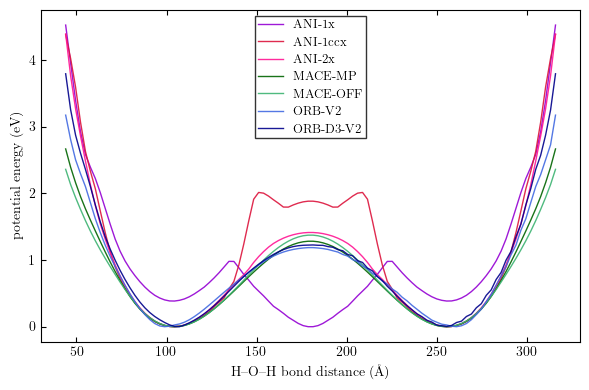

In [13]:
# set working directory for the test
working_dir = './PES_angles/'
if not os.path.isdir('./PES_angles'):
    os.makedirs(working_dir)

# define the molecule
mol = molecule('H2O')
name = 'water'

# decide the atoms
for atom in mol:
    print(f'{atom.symbol}\t{atom.position}')

# check the initial angle
initial_angle = mol.get_angle(a1=1, a2=0, a3=2)
print(f'Initial angle\t{initial_angle:.6f} deg')

# [0, 360-2*initial_angle]
# search_space=[-50, 220]
angle_list, energies = evaluate_angle(mol, [1, 0, 2], calculator_list, search_space=[-60, 360-2*initial_angle+60], resolution=100, save_dir=working_dir)
print(f'angles\t{angle_list}')
print(f'energies\t{energies}')

plot_angle(mol, [1, 0, 2], angle_list, energies, calculator_names, color_dict=color_dict, save_dir=working_dir, name='water')

C	[ 1.168181 -0.400382  0.      ]
C	[0.       0.559462 0.      ]
O	[-1.190083 -0.227669  0.      ]
H	[-1.946623  0.381525  0.      ]
H	[0.042557 1.207508 0.886933]
H	[ 0.042557  1.207508 -0.886933]
H	[2.115891 0.1448   0.      ]
H	[ 1.128599 -1.037234  0.885881]
H	[ 1.128599 -1.037234 -0.885881]
1.426840130515679
Initial angle	107.110540 deg
./PES_angles/C-C-O_scan.traj
Initial angle	107.110540 deg
computing C-C-O PES	scan range [97.11, 117.11] deg
angles	[ 97.11053951  98.16317109  99.21580267 100.26843425 101.32106583
 102.37369741 103.42632899 104.47896057 105.53159215 106.58422373
 107.6368553  108.68948688 109.74211846 110.79475004 111.84738162
 112.9000132  113.95264478 115.00527636 116.05790794 117.11053951]
energies	[[-4217.305680392746, -4217.345710971562, -4217.380955097654, -4217.411334259715, -4217.436853729001, -4217.457634288239, -4217.473840208022, -4217.485568753162, -4217.492998386096, -4217.496398599798, -4217.495965748564, -4217.4917653683015, -4217.483957573418, -42

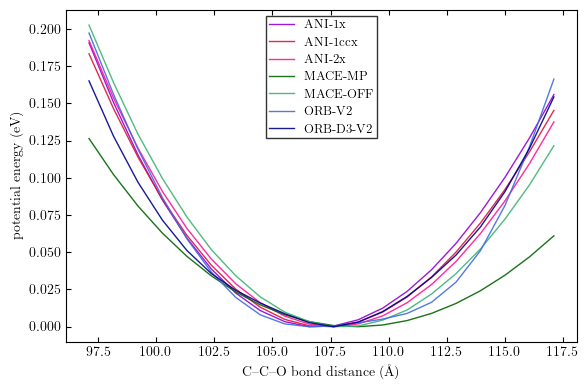

In [14]:
# set working directory for the test
working_dir = './PES_angles/'
if not os.path.isdir('./PES_angles'):
    os.makedirs(working_dir)

# define the molecule
mol = molecule('CH3CH2OH')
mol_name = 'ethanol'
mask = [1, 1, 0, 0, 1, 1, 1, 1, 1]
mask = [0, 0, 1, 1, 0, 0, 0, 0, 0]

#view(mol)


# define the calculators
#calculator_list = [ani1x_calc]
#calculator_names = ['ANI-1x']
#calculator_colors = ['darkviolet']

# decide the atoms
for atom in mol:
    print(f'{atom.symbol}\t{atom.position}')

# check the initial angle
indexs = [0, 1, 2]
initial_angle = mol.get_angle(a1=indexs[0], a2=indexs[1], a3=indexs[2])
print(mol.get_distance(a0=1, a1=2))
print(f'Initial angle\t{initial_angle:.6f} deg')

# [0, 360-2*initial_angle]
# search_space=[-50, 220]
angle_list, energies = evaluate_angle(mol, indexs, calculator_list, search_space=[-10, 10], resolution=20, save_dir=working_dir, mask=mask)
print(f'angles\t{angle_list}')
print(f'energies\t{energies}')
print(mol.get_distance(a0=1, a1=2))

plot_angle(mol, indexs, angle_list, energies, calculator_names, color_dict=color_dict, save_dir=working_dir, name=mol_name)

In [ ]:
traj = trajectory.TrajectoryReader('./PES_angles/C-C-O_scan.traj')
view(traj)

<Popen: returncode: None args: ['/Users/sergiortizropero/miniconda3/envs/ASE...>

Traceback (most recent call last):
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10